<a href="https://colab.research.google.com/github/dalexa10/Numerical_Methods_PDEs/blob/main/HW4_Finite_Elements/fe-assembly-quadratics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from matplotlib import tri

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'

In [2]:
!wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.e
!wget https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.v

--2023-04-21 22:12:11--  https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.e
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763 (7.6K) [text/plain]
Saving to: ‘mesh.e’

mesh.e              100%[===================>]   7.58K  --.-KB/s    in 0s      

2023-04-21 22:12:12 (71.5 MB/s) - ‘mesh.e’ saved [7763/7763]

--2023-04-21 22:12:12--  https://raw.githubusercontent.com/lukeolson/cs555-demos/main/mesh.v
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19020 (19K) [text/plain]
Saving to: ‘mesh.v’

mesh.v             

In [3]:
def generate_quadratic(V, E, return_edges=False):
    """Generate a quadratic element list by adding midpoints to each edge.
    Parameters
    ----------
    V : ndarray
        nv x 2 list of coordinates
    E : ndarray
        ne x 3 list of vertices
    return_edges : bool
        indicate whether list of the refined edges is returned
    Returns
    -------
    V2 : ndarray
        nv2 x 2 list of coordinates
    E2 : ndarray
        ne2 x 6 list of vertices
    Edges : ndarray
        ned x 2 list of edges where the midpoint is generated
    Notes
    -----
        - midpoints are introduced and globally numbered at the end of the vertex list
        - the element list includes the new list beteen v0-v1, v1-v2, and v2-v0
    Examples
    --------
    >>> import numpy as np
    >>> from pyamg.gallery import fem
    >>> V = np.array([[0.,0.], [1.,0.], [0.,1.], [1.,1.]])
    >>> E = np.array([[0,1,2], [2,3,1]])
    >>> V2, E2 = fem.generate_quadratic(V, E)
    >>> print(V2)
    [[0.  0. ]
     [1.  0. ]
     [0.  1. ]
     [1.  1. ]
     [0.5 0. ]
     [0.5 0.5]
     [0.  0.5]
     [0.5 1. ]
     [1.  0.5]]
    >>> print(E2)
    [[0 1 2 4 5 6]
     [2 3 1 7 8 5]]
    """
    if not isinstance(V, np.ndarray) or not isinstance(E, np.ndarray):
        raise ValueError('V and E must be ndarray')

    if V.shape[1] != 2 or E.shape[1] != 3:
        raise ValueError('V should be nv x 2 and E should be ne x 3')

    ne = E.shape[0]

    # make a vertext-to-vertex graph
    ID = np.kron(np.arange(0, ne), np.ones((3,), dtype=int))
    G = sparse.coo_matrix((np.ones((ne*3,), dtype=int), (E.ravel(), ID,)))
    V2V = G * G.T

    # from the vertex graph, get the edges and create new midpoints
    V2Vmid = sparse.tril(V2V, -1)
    Edges = np.vstack((V2Vmid.row, V2Vmid.col)).T
    Vmid = (V[Edges[:, 0], :] + V[Edges[:, 1], :]) / 2.0
    V = np.vstack((V, Vmid))

    # enumerate the new midpoints for the edges
    # V2Vmid[i,j] will have the new number of the midpoint between i and j
    maxindex = E.max() + 1
    newID = maxindex + np.arange(Edges.shape[0])
    V2Vmid.data = newID
    V2Vmid = V2Vmid + V2Vmid.T

    # from the midpoints, extend E
    E = np.hstack((E, np.zeros((E.shape[0], 3), dtype=int)))
    E[:, 3] = V2Vmid[E[:, 0], E[:, 1]]
    E[:, 4] = V2Vmid[E[:, 1], E[:, 2]]
    E[:, 5] = V2Vmid[E[:, 2], E[:, 0]]

    if return_edges:
        return V, E, Edges

    return V, E

In [4]:
def applybc(A, b, V, E):
    """
    Applied zero Dirichlet conditions everywhere
    
    Returns
    -------
    A : sparse matrix
        Modified, assembled sparse matrix
    b : ndarray
        Modified, assembled right-hand side
    """
    tol = 1e-14
    id1 = np.where(abs(Y+1) < tol)[0]
    id2 = np.where(abs(Y-1) < tol)[0]
    id3 = np.where(abs(X+1) < tol)[0]
    id4 = np.where(abs(X-1) < tol)[0]
    I = np.vstack((id1, id2, id3, id4)).ravel()
    I = np.unique(I)
    Dflag = np.zeros(len(A.data), dtype=bool)
    Dflag[I] = True
    
    for k, (i, j) in enumerate(zip(A.row, A.col)):
        if Dflag[i] or Dflag[j]:
            if i == j:
                A.data[k] = 1.0
            else:
                A.data[k] = 0.0

    return A, b

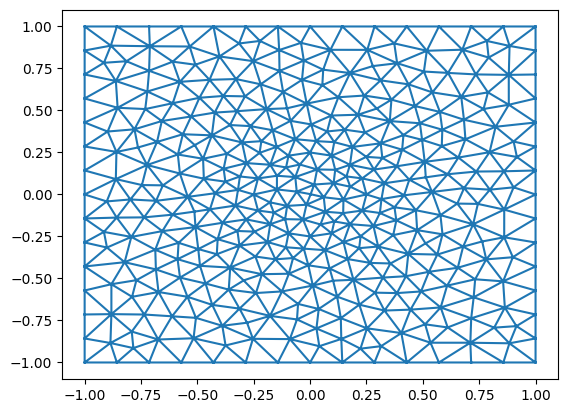

In [5]:
V = np.loadtxt('mesh.v')
E = np.loadtxt('mesh.e', dtype=int)

V2, E2, edges2 = generate_quadratic(V, E, return_edges=True)

X, Y = V2[:, 0], V2[:, 1]
plt.triplot(X, Y, E2[:, :3])

In [6]:
def kappa(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 2.0

def f(x, y):
    if np.sqrt(x**2 + y**2) <= 0.25:
        return 100.0
    return 0.0

In [10]:
ne = E2.shape[0]

# allocate sparse matrix arrays
m = 6  # for quadratics
AA = np.zeros((ne, m**2))
IA = np.zeros((ne, m**2), dtype=int)
JA = np.zeros((ne, m**2), dtype=int)
bb = np.zeros((ne, m))
ib = np.zeros((ne, m), dtype=int)
jb = np.zeros((ne, m), dtype=int)

# Assemble A and b
for ei in range(0, ne):
    # Step 1: set the vertices and indices
    K = E2[ei, :]
    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]

    # Step 2: compute the Jacobian, inv, and det
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = np.linalg.inv(J.T)
    detJ = np.linalg.det(J)

    # Step 3a: set up quadrature nodes in the triangle
    ww = np.array([0.44676317935602256, 0.44676317935602256, 0.44676317935602256,
                   0.21990348731064327, 0.21990348731064327, 0.21990348731064327])
    xy = np.array([[-0.10810301816807008, -0.78379396366385990],
                   [-0.10810301816806966, -0.10810301816807061],
                   [-0.78379396366386020, -0.10810301816806944],
                   [-0.81684757298045740, -0.81684757298045920],
                   [0.63369514596091700, -0.81684757298045810],
                   [-0.81684757298045870, 0.63369514596091750]])
    xx, yy = (xy[:, 0]+1)/2, (xy[:, 1]+1)/2
    ww *= 0.5

    # Steb 3b: set element matrix and right-hand side to zero
    Aelem = np.zeros((m, m))
    belem = np.zeros((m,1))
    
    # Step 3c: loop over each quadrature weight
    for w, x, y in zip(ww, xx, yy):
        # Step 3d: set quadratic basis at the quadrature points
        basis = np.array([[(1 - x - y) * (1 - 2 * x - 2 * y)],
                          [x * (2 * x - 1)],
                          [y * (2 * y - 1)],
                          [4 * x * (1 - x - y)],
                          [4 * x * y],
                          [4 * y * (1 - x - y)]])

        dbasis = np.array([[4 * x + 4 * y - 3, 4 * x + 4 * y - 3],
                            [4 * x - 1, 0],
                            [0, 4 * y - 1],
                            [-8 * x - 4 * y + 4, -4 * x],
                            [4 * y, 4 * x],
                            [-4 * y, - 4 * x - 8 * y + 4]]).transpose()

        # Step 4: construct J^{-T} dphi
        dphi = invJ.dot(dbasis)

        # Step 5: add to element matrix
        xt, yt = J.dot(np.array([x, y])) + np.array([x0, y0])
        kappaelem = kappa(xt, yt)
        Aelem += (detJ / 2) * w * kappaelem * dphi.T @ dphi

        # Step 6: add to element rhs
        belem += (detJ / 2) * w * f(xt, yt) * basis

    # Step 7
    AA[ei, :] = Aelem.ravel()
    IA[ei, :] = np.repeat(K[np.arange(m)], m)
    JA[ei, :] = np.tile(K[np.arange(m)], m)
    bb[ei, :] = belem.ravel()
    ib[ei, :] = K[np.arange(m)]
    jb[ei, :] = 0

# convert matrices
A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A.sum_duplicates()
b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel()))).toarray().ravel()

In [11]:
A, b = applybc(A, b, V2, E2)

In [12]:
u = sla.spsolve(A.tocsr(), b)  # see CS556

In [13]:
fig = ff.create_trisurf(x=X, y=Y, z=u,
                        simplices=E)
py.iplot(fig, filename='surf')
fig.show(renderer="colab")